# LGMVIP - Data Science June 2023
Author : Nanthitha B

Task 2: Stock Market Prediction and Forecasting using stacked LSTM


Level: Beginner 

In [4]:
!pip install tensorflow

In [5]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd
import numpy as np
import math 
warnings.filterwarnings('ignore')

In [6]:
d = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
d.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [7]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [8]:
d.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [9]:
d['Date'] = pd.to_datetime(d['Date'])
d.dtypes

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity             int64
Turnover (Lacs)                float64
dtype: object

In [10]:
d = d.sort_values('Date')
d.head()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


Text(0, 0.5, 'Close')

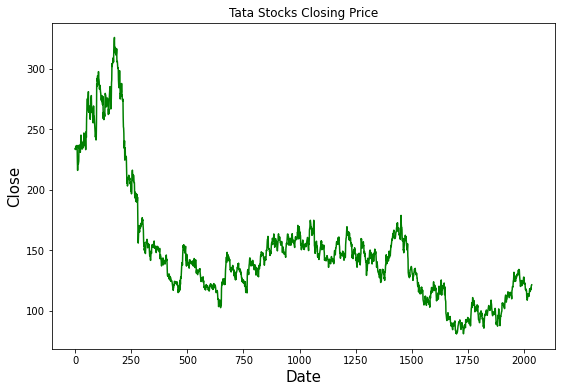

In [11]:
plt.figure(figsize = (9,6))
plt.title('Tata Stocks Closing Price')
plt.plot(d['Close'],'g')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Close',fontsize=15)

<AxesSubplot:>

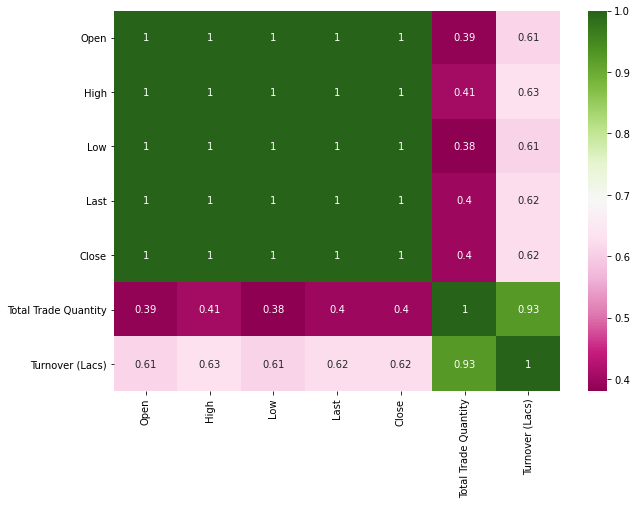

In [12]:
dcorr = d.corr()
top_corr_features = dcorr.index
plt.figure(figsize=(10,7))
sns.heatmap(d[top_corr_features].corr(), annot=True, cmap="PiYG")

# MinMaxScaler
From the original dataset, we can tell that each of our target value are in close proximity to one another. So, we will use MinMaxScaler to scale down all the target variables in the range of (0, 1) for the ease of computation.

In [13]:
data_close = d.reset_index()['Close']
data_close.head()
scaler = MinMaxScaler(feature_range = (0, 1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1, 1))

# Splitting train, Test data

In [14]:
train_size = int(len(data_close)*0.70)
test_size = len(data_close) - train_size
train, test = data_close[0 : train_size, :], data_close[train_size : len(data_close), :1]

In [15]:
def create_matrix(ds, time_step=1):
    dataX, dataY = [], []
    for i in range(len(ds)-time_step-1):
        a = ds[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(ds[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [16]:
step=100 
X_train, y_train = create_matrix(train, step)
X_test, y_test = create_matrix(test, step)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1323, 100) (1323,)
(510, 100) (510,)


In [17]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM Model

In [18]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=77, batch_size=64, verbose=1, shuffle=True)

Epoch 1/77
19/19 [==============================] - 3s 159ms/step - loss: 1.5732e-04 - val_loss: 1.6179e-04
Epoch 2/77
19/19 [==============================] - 3s 147ms/step - loss: 1.5404e-04 - val_loss: 1.2402e-04
Epoch 3/77
19/19 [==============================] - 3s 157ms/step - loss: 1.4467e-04 - val_loss: 1.6022e-04
Epoch 4/77
19/19 [==============================] - 3s 159ms/step - loss: 1.4057e-04 - val_loss: 1.1962e-04
Epoch 5/77
19/19 [==============================] - 3s 150ms/step - loss: 1.3265e-04 - val_loss: 1.2620e-04
Epoch 6/77
19/19 [==============================] - 3s 152ms/step - loss: 1.4962e-04 - val_loss: 1.4216e-04
Epoch 7/77
19/19 [==============================] - 4s 210ms/step - loss: 1.6566e-04 - val_loss: 1.3702e-04
Epoch 8/77
19/19 [==============================] - 5s 263ms/step - loss: 1.4193e-04 - val_loss: 1.5990e-04
Epoch 9/77
19/19 [==============================] - 4s 196ms/step - loss: 1.4082e-04 - val_loss: 1.3913e-04
Epoch 10/77
19/19 [=========

In [22]:
train_predict = model.predict(X_train)

test_predict = model.predict(X_test)

16/16 [==============================] - 1s 43ms/step


In [23]:
# Reversing the MinMax Scaler
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [24]:
math.sqrt(mean_squared_error(y_train, train_predict))
math.sqrt(mean_squared_error(y_test,test_predict))

206.70856112705113

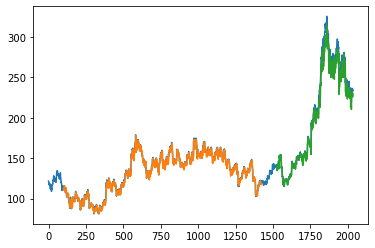

In [25]:
### Visualise the Predictions
look_back = 100
train_num_pyredict_plot = np.empty_like(data_close)
train_num_pyredict_plot[:, :] = np.nan
train_num_pyredict_plot[look_back : len(train_predict) + look_back, :] = train_predict
test_predict_plot = np.empty_like(data_close)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1 : len(data_close) - 1, :] = test_predict
plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_num_pyredict_plot)
plt.plot(test_predict_plot)
plt.show()

In [26]:
### Future Prediction Model
x_inum_pyut=test[307:].reshape(1, -1)
x_inum_pyut.shape
temp_inum_pyut = list(x_inum_pyut)
temp_inum_pyut = temp_inum_pyut[0].tolist()
temp_inum_pyut = list(x_inum_pyut)
temp_inum_pyut = temp_inum_pyut[0].tolist()

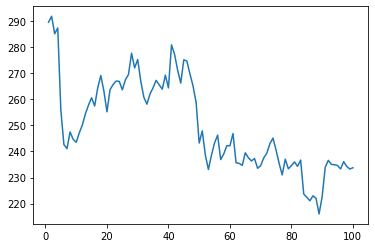

In [27]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)
plt.plot(day_new, scaler.inverse_transform(data_close[1935 : ]))